# Multi-dimensional convolution timing benchmarks - multiple virtual sources

### Author: M.Ravasi

This notebook perfoms multi-dimensional convolution with the same reflection response(s) used in the Marchenko redatuming examples with the aim of comparing the performance of the core operation with respect to *data size* and *number of compute resources*. 

Here, we consider the case with a multiple virtual sources.

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import psutil
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import dask.array as da
import zarr
import pylops
import pylops_distributed
import scooby

from datetime import date
from timeit import repeat
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def total_ram():
    tmem = psutil.virtual_memory().total
    return '{:.1f} GB'.format(tmem / (1024.0 ** 3))

In [19]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [20]:
client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn085:8786')


In [21]:
client.restart()
client

Client Scheduler: tcp://be-linrgsn085:8786 Dashboard: http://be-linrgsn085:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.08 TB


In [22]:
nworkers = len(np.array(list(client.ncores().values())))
ncores = np.sum(np.array(list(client.ncores().values())))
print('Nworkers', nworkers)
print('Ncores', ncores)

Nworkers 8
Ncores 96


## Inputs

Input parameters 

In [23]:
# MDC parameters
vel = 2400.0        # velocity
nfmax = 300         # max frequency for MDC (#samples)
darea = 1           # areal extent for spatial integration (not needed here...)
nvs = 50            # number of virtual sources
subsampling = 8     # subsampling of src-recs compared to original data
ffirst = True       # frequency in first axis of zarr file
rechunk = True      # rechunk R
rebalance = True    # rebalance R across nodes

# Timing parameters
nrepeat = min(2, subsampling+1)
ntime = min(5, subsampling+1)

    
inputfile_aux = os.environ["STORE_PATH"]+'3DMarchenko_auxiliary_2.npz' 
zarrfile = os.environ["STORE_PATH"]+'input3D_sub%d%s.zarr' % \
    (subsampling, '_ffirst' if ffirst else '')

Load auxiliary input (contains sources, recs, virtual source etc.)

In [24]:
inputdata_aux = np.load(inputfile_aux)

Read and visualize geometry

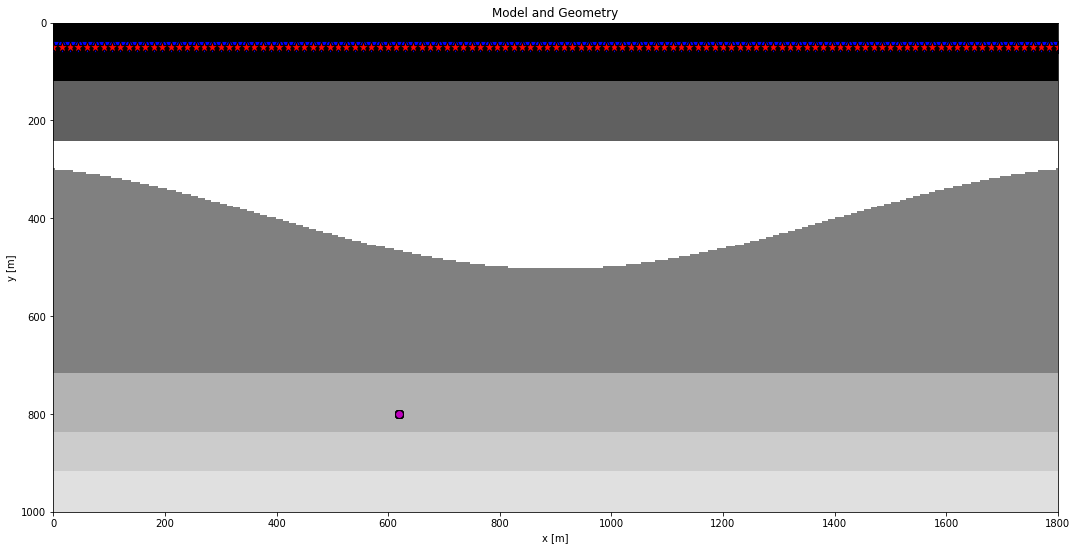

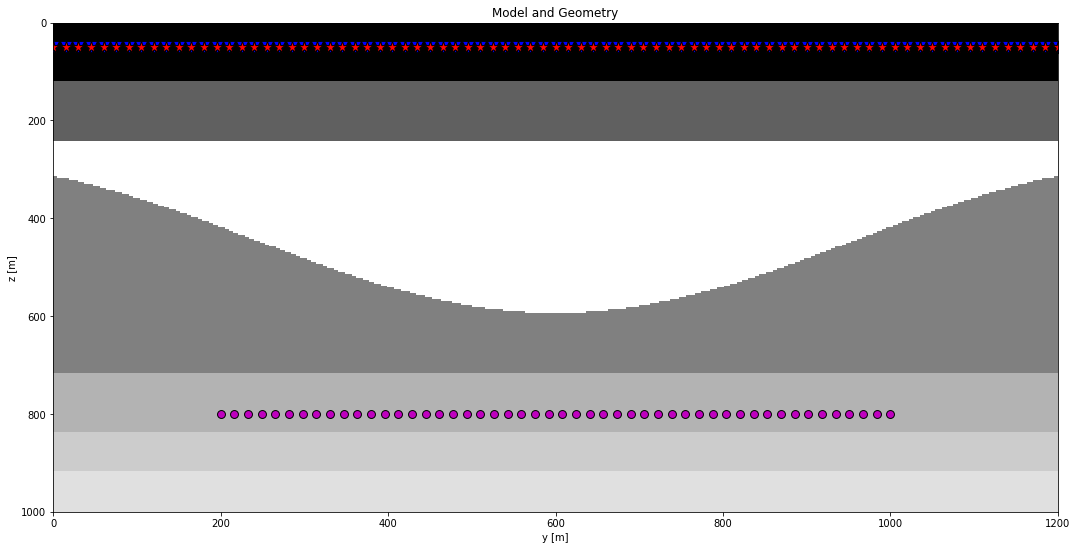

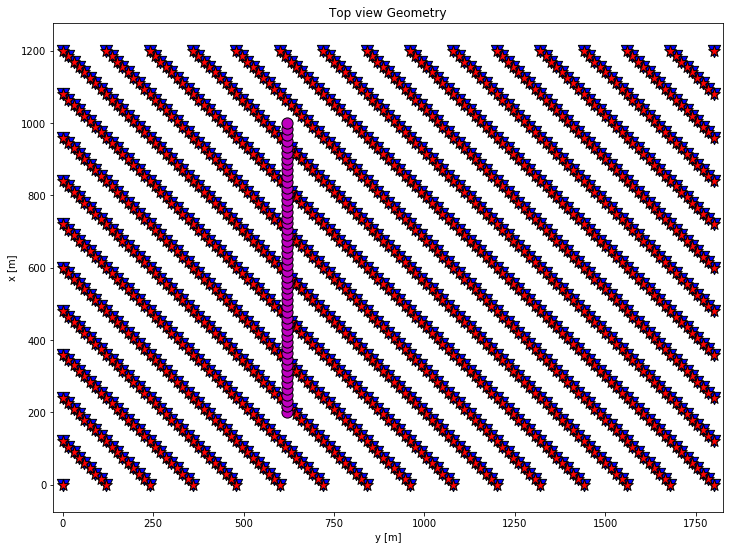

In [25]:
# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points (y, x, z)
vs = np.vstack((620*np.ones(nvs), np.linspace(200, 1000, nvs), 800*np.ones(nvs)))
               
# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(x-vs[1, 0]))].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(y-vs[0, 0]))].T, cmap='gray', extent = (y[0], y[-1], z[-1], z[0]))
plt.scatter(r[1, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[1, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[1], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('y [m]'),plt.ylabel('z [m]'),plt.title('Model and Geometry')
plt.xlim(y[0], y[-1]);

plt.figure(figsize=(12,9))
plt.scatter(r[0],  r[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=500, c='m', edgecolors='k')
plt.axis('equal')
plt.xlabel('y [m]'),plt.ylabel('x [m]'),plt.title('Top view Geometry')
plt.xlim(x[0], x[-1]);

Create subsurface field to convolve to the reflection response

In [26]:
# Direct arrival window - traveltime
distVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2 +
                 (vs[1]-r[1][:, np.newaxis])**2 +
                 (vs[2]-r[2][:, np.newaxis])**2)
directVS = distVS/vel

wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)
G0sub = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=2**11, dist=distVS[:,ivs], kind='3d').T

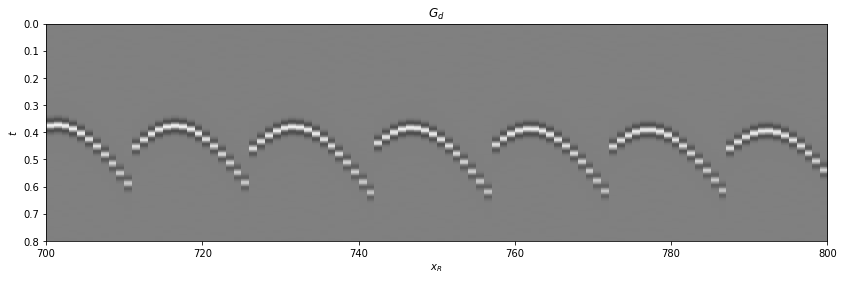

In [27]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.imshow(G0sub.transpose(1, 0, 2).reshape(nr*nvs, nt).T, cmap='gray', vmin=-1e-4, vmax=1e-4, 
          interpolation=None, extent=(0, nr*nvs, t[-1], 0))
ax.set_title(r'$G_d$')
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_ylim(0.8, 0)
ax.set_xlim(700, 800);

Read Reflection response from Zarr file

In [28]:
dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R

In [29]:
nchunks = [max(nfmax // ncores, 1), ns, nr]
if not ffirst:
    dRtwosided_fft = dRtwosided_fft.transpose(2, 1, 0)
if rechunk:
    dRtwosided_fft = dRtwosided_fft.rechunk(nchunks)
else:
    nchunks = dRtwosided_fft.chunksize
dRtwosided_fft = client.persist(dRtwosided_fft)
client.rebalance(dRtwosided_fft)

dRtwosided_fft

,Array,Chunk
Bytes,3.61 GB,36.07 MB
Shape,"(300, 1226, 1226)","(3, 1226, 1226)"
Count,100 Tasks,100 Chunks
Type,complex64,numpy.ndarray


Create distributed MDC operator

In [30]:
# Operators
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=nvs, dt=dt, dr=darea, 
            twosided=True, saveGt=False)

# Input focusing function
dfd_plus = np.concatenate((np.flip(G0sub, axis=-1).transpose(2, 0, 1), np.zeros((nt-1, nr, nvs)))).astype(np.float32)
dfd_plus = da.from_array(dfd_plus).rechunk(dfd_plus.shape)

Run standard redatuming as benchmark

In [31]:
dp0_minus = dRop.matvec(dfd_plus.flatten())

In [32]:
p0_minus = dp0_minus.compute()
p0_minus = p0_minus.reshape((2*nt-1), nr, nvs)

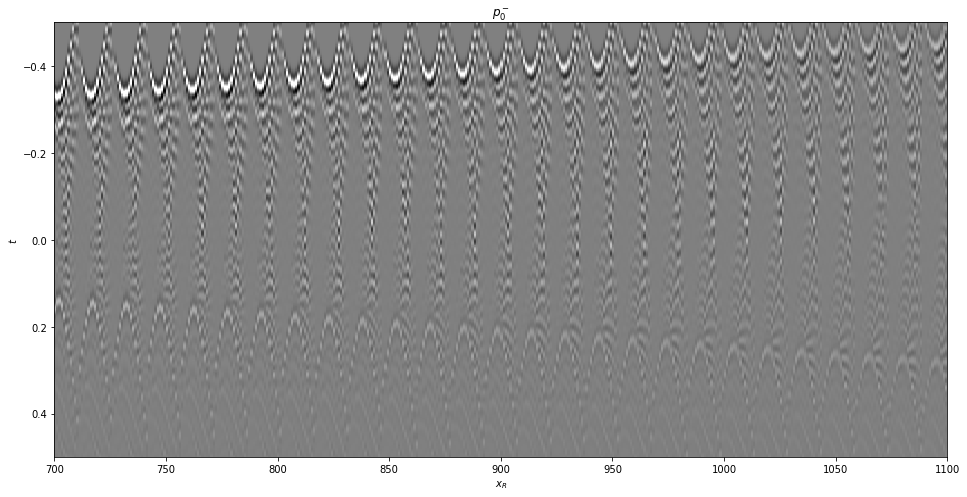

In [39]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 8))
ax.imshow(p0_minus.transpose(2, 1, 0).reshape(nr*nvs, 2*nt-1).T, cmap='gray', vmin=-2e-8, vmax=2e-8, 
          interpolation=None, extent=(0, nr*nvs, t[-1], -t[-1]))
ax.set_title(r'$p_0^-$')
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_ylim(0.5, -0.5)
ax.set_xlim(700, 1100);

Time forward

In [18]:
dp0_forw = dRop.matvec(dfd_plus.flatten())

exctime = np.array(repeat(lambda: dp0_forw.compute(), number=ntime, repeat=nrepeat))
meantime, stdtime = np.mean(exctime/ntime), np.std(exctime/ntime)

In [19]:
df = pd.DataFrame(dict(nworkers=nworkers, ncores=ncores, ram=total_ram(), 
                       subsampling=subsampling, ffirst=ffirst,
                       meantime=meantime, stdtime=stdtime, 
                       nchunks=str(nchunks), rebalance=rebalance,
                       nrepeat=nrepeat, ntime=ntime, nvs=nvs,
                       time=date.today()), index=[0])

# add to csv file
header=True
if os.path.isfile('Benchmarks/benchmark_forwmulti.csv'):
    df_other = pd.read_csv('Benchmarks/benchmark_forwmulti.csv')
    df = pd.concat([df_other, df])
df.to_csv('Benchmarks/benchmark_forwmulti.csv', index=False)

In [20]:
df = pd.read_csv('Benchmarks/benchmark_forwmulti.csv')
display(df)

,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nvs,nworkers,ram,rebalance,stdtime,subsampling,time
0,True,8.615038,"[3, 1226, 1226]",96,2,5,5,8,126.0 GB,True,0.382233,8,2019-11-18
1,True,17.752413,"[3, 1226, 1226]",96,2,5,25,8,126.0 GB,True,0.761968,8,2019-11-18
2,True,6.238845,"[3, 1226, 1226]",96,2,5,1,8,126.0 GB,True,0.028211,8,2019-11-18
3,True,31.043209,"[3, 1226, 1226]",96,2,5,50,8,126.0 GB,True,0.392060,8,2019-11-18
4,True,10.570028,"[6, 1226, 1226]",48,2,5,5,4,126.0 GB,True,0.111563,8,2019-11-19
5,True,9.166759,"[6, 1226, 1226]",48,2,5,1,4,126.0 GB,True,0.923153,8,2019-11-19
6,True,25.545733,"[6, 1226, 1226]",48,2,5,25,4,126.0 GB,True,0.576011,8,2019-11-19
7,True,64.366888,"[6, 1226, 1226]",48,2,5,50,4,126.0 GB,True,1.250990,8,2019-11-19
8,True,35.179387,"[3, 1226, 1226]",96,2,5,50,8,126.0 GB,True,1.984675,8,2019-12-01


Time adjoint

In [21]:
dp0_adj = dRop.rmatvec(dfd_plus.flatten())

exctime = np.array(repeat(lambda: dp0_adj.compute(), number=ntime, repeat=nrepeat))
meantime, stdtime = np.mean(exctime/ntime), np.std(exctime/ntime)

In [22]:
df = pd.DataFrame(dict(nworkers=nworkers, ncores=ncores, ram=total_ram(), 
                       subsampling=subsampling, ffirst=ffirst,
                       meantime=meantime, stdtime=stdtime, 
                       nchunks=str(nchunks), rebalance=rebalance,
                       nrepeat=nrepeat, ntime=ntime, nvs=nvs,
                       time=date.today()), index=[0])

# add to csv file
header=True
if os.path.isfile('Benchmarks/benchmark_adjmulti.csv'):
    df_other = pd.read_csv('Benchmarks/benchmark_adjmulti.csv')
    df = pd.concat([df_other, df])
df.to_csv('Benchmarks/benchmark_adjmulti.csv', index=False)

In [23]:
df = pd.read_csv('Benchmarks/benchmark_adjmulti.csv')
display(df)

,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nvs,nworkers,ram,rebalance,stdtime,subsampling,time
0,True,8.600582,"[3, 1226, 1226]",96,2,5,NaN,8,126.0 GB,True,0.705919,8,2019-11-18
1,True,8.956256,"[3, 1226, 1226]",96,2,5,10.0,8,126.0 GB,True,0.005198,8,2019-11-18
2,True,7.389975,"[3, 1226, 1226]",96,2,5,5.0,8,126.0 GB,True,0.279397,8,2019-11-18
3,True,19.145758,"[3, 1226, 1226]",96,2,5,25.0,8,126.0 GB,True,0.363112,8,2019-11-18
4,True,6.548507,"[3, 1226, 1226]",96,2,5,1.0,8,126.0 GB,True,0.192934,8,2019-11-18
5,True,34.022356,"[3, 1226, 1226]",96,2,5,50.0,8,126.0 GB,True,1.878412,8,2019-11-18
6,True,10.215113,"[6, 1226, 1226]",48,2,5,5.0,4,126.0 GB,True,0.833674,8,2019-11-19
7,True,9.510499,"[6, 1226, 1226]",48,2,5,1.0,4,126.0 GB,True,0.822790,8,2019-11-19
8,True,25.904574,"[6, 1226, 1226]",48,2,5,25.0,4,126.0 GB,True,0.190692,8,2019-11-19
9,True,63.062070,"[6, 1226, 1226]",48,2,5,50.0,4,126.0 GB,True,1.093918,8,2019-11-19


In [24]:
scooby.Report()

--------------------------------------------------------------------------------
  Date: Sun Dec 01 14:23:12 2019 CET

             Linux : OS
                12 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
          126.0 GB : RAM
           Jupyter : Environment

  Python 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]

            1.16.4 : numpy
             1.3.0 : scipy
             7.6.1 : IPython
             3.1.0 : matplotlib
             0.4.3 : scooby

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

In [25]:
client.close()